In [1]:
import glob
import chess_SL_E7_lib as lib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import chess
import numpy as np

In [2]:
_ = lib.fen_str_to_flat_tensor('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1')

In [3]:
_ = lib.fen_str_to_3d_tensor('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1')

In [4]:
MODEL_NUM = 7
MODEL_VERSION = 1

path = "../Data/DataTrain"

letters_in = 'abcdefghijklmno'
letters_out = 'adhlp'

csv_files1 = []
csv_files2 = []

for let in letters_in:
    csv_files1.extend(glob.glob(f'{path}/Chess_Jan_{let}*'))

for let_ in letters_out:
    csv_files2.extend(glob.glob(f'{path}/Chess_Jan_{let_}*'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Models Trained
- V1 -> Predictor: tensor [64,64]
- V2 -> Predictor: tensor [64,64]
- V3 -> Predictor: tensor [64,64]
- V4 -> Predictor: tensor [64,64]

- E1 -> Epochs: 200, SGD(Learning Rate: 0.030, Momentum = 0.9), Loss: L1Loss, Training: "a*", Validation: "a*" |||| Vars: FEN, white_active, is_check |||| Predictor: CP
- E2 -> Epochs: 200, SGD(Learning Rate: 0.035, Momentum = 0.9), Loss: L1Loss, Training: "a*", Validation: "b*" |||| Vars: FEN, white_active, is_check |||| Predictor: CP
- E3 -> Epochs: 75, Adam(Learning Rate: 0.006, Mometum = 0.9), Loss: L1Loss, Training: "a|b*", Validation: "c|d*" |||| Vars: FEN, white_active, is_check, is_capture |||| Predictor: CP
- E3.1 -> Epochs: 50, Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c*", Validation: "d|e|f*" |||| Vars: FEN, white_active, is_check, is_capture |||| Predictor: CP
- E3.2 -> Epochs: 40, Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d*", Validation: "d|e|f|g*" |||| Vars: FEN, white_active, is_check, is_capture |||| Predictor: CP
- E4.1 -> Epochs: 25, Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d*", Validation: "d|e|f|g*" |||| Vars: FEN, white_active, is_capture |||| Predictor: CP
- E5.1 -> Epochs: 25, NN(1 conv, 2 FC), Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d*", Validation: "d|e*" |||| Vars: FEN |||| Predictor: CP
- E5.2 -> Epochs: 50, NN(1 conv, 2 FC), Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d|e*", Validation: "e|f*" |||| Vars: FEN |||| Predictor: CP
- E6.1 -> Epochs: 25, NN(2 conv, 2 FC), Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d*", Validation: "d|e*" |||| Vars: FEN |||| Predictor: CP
- E6.2 -> Epochs: 50, NN(2 conv, 2 FC), Adam(Learning Rate: 0.006), Loss: L1Loss, Training: "a|b|c|d|e*", Validation: "e|f*" |||| Vars: FEN |||| Predictor: CP

In [5]:
# Create a dataset
dataset1 = lib.ChessIterableDataset(csv_files1, chunksize = 50000)
dataset2 = lib.ChessIterableDataset(csv_files2, chunksize = 50000)

# Create a data loader
train_data_loader = DataLoader(dataset1, batch_size = 25000)
val_data_loader = DataLoader(dataset2, batch_size = 25000)

# Create a model
# model = lib.EvalNet()
model = torch.load(f'./models_EL/model_E6-2.pth')
model = model.to(device)

criterion = nn.L1Loss() # nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.035, momentum=0.9)

optimizer = optim.Adam(model.parameters(), lr=0.0061)

# Train the model
training_loss_history, validation_loss_history = lib.train(model, train_data_loader, val_data_loader, criterion, optimizer, num_epochs=30)


Begin Training!
Epoch 1/30, Training Loss: 1.37242, Validation Loss: 1.35098
Epoch 2/30, Training Loss: 1.34638, Validation Loss: 1.33735
Epoch 3/30, Training Loss: 1.33281, Validation Loss: 1.33349
Epoch 4/30, Training Loss: 1.32650, Validation Loss: 1.32320
Epoch 5/30, Training Loss: 1.31686, Validation Loss: 1.31119
Epoch 6/30, Training Loss: 1.31218, Validation Loss: 1.29928
Epoch 7/30, Training Loss: 1.30516, Validation Loss: 1.30949
Epoch 8/30, Training Loss: 1.30182, Validation Loss: 1.28859
Epoch 9/30, Training Loss: 1.29272, Validation Loss: 1.29813
Epoch 10/30, Training Loss: 1.29053, Validation Loss: 1.29536
Epoch 11/30, Training Loss: 1.28783, Validation Loss: 1.28569
Epoch 12/30, Training Loss: 1.28314, Validation Loss: 1.28927
Epoch 13/30, Training Loss: 1.27817, Validation Loss: 1.27422
Epoch 14/30, Training Loss: 1.27772, Validation Loss: 1.28501
Epoch 15/30, Training Loss: 1.27360, Validation Loss: 1.28198
Epoch 16/30, Training Loss: 1.27079, Validation Loss: 1.26507
E

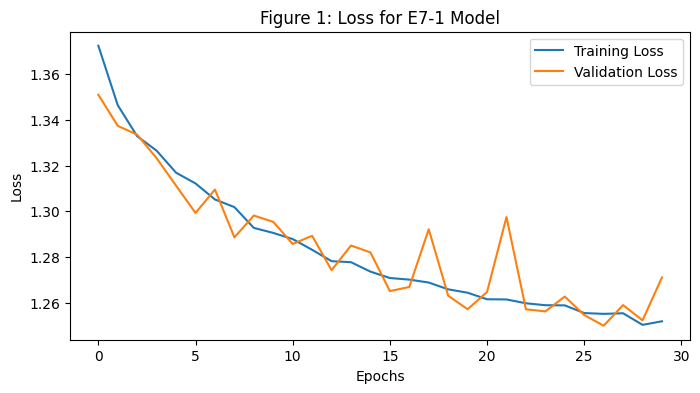

In [6]:
torch.save(model, f'model_E{MODEL_NUM}-{MODEL_VERSION}.pth')

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(training_loss_history, label = 'Training Loss')
plt.plot(validation_loss_history, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim(0, None)
plt.title(f'Figure 1: Loss for E{MODEL_NUM}-{MODEL_VERSION} Model')
plt.legend()
plt.savefig(f'Loss_E{MODEL_NUM}-{MODEL_VERSION}.png')
plt.show()



# NOTE TO SELF - TEST NEW STOCHASTIC PREDICTION FUNCTION

In [7]:
import pickle

pickle.dump(training_loss_history, open(f'pickle/training_loss_history_E{MODEL_NUM}-{MODEL_VERSION}.pkl', 'wb'))
pickle.dump(validation_loss_history, open(f'pickle/validation_loss_history_E{MODEL_NUM}-{MODEL_VERSION}.pkl', 'wb'))

In [8]:
model_loaded = torch.load(f'model_E{MODEL_NUM}-{MODEL_VERSION}.pth')

In [9]:
board = chess.Board()

g1f3


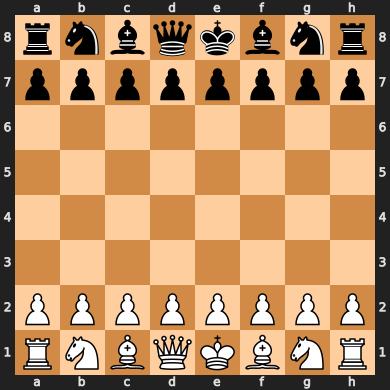

In [10]:
move = lib.predict(model_loaded, board.fen())
print(move)
board

In [11]:
board.push_uci(move)
board

TypeError: object of type 'Move' has no len()

In [ ]:
move = lib.predict(model_loaded, board.fen())

In [ ]:
move = 'e4f6'

In [ ]:
# TODO : make prediction function
# TODO : speed up